# Mini-proyecto: Clasificación multiclase en Wine

- Preparar datos (split estratificado, estandarización sin fuga)
- Entrenar Regresión Logística Multinomial (Softmax) con `lbfgs`
- Evaluar con classification_report, matriz de confusión, ROC/AUC macro y micro.
- Hacer búsqueda de hiperparámetros (GridSearchCV) de forma segura.
- Interpretar coeficientes del modelo y revisar errores

## 1. Instalación de librerias necesarias para ejecutar el código.

- load_wine = llamamos al dataset que usaremos.
- train_test_split = nos permite sepaparar el dataset para entrenamiento y testeo.
- GridSearchCV = se ejecuta a través de los diferentes parámetros que se introducen en la cuadrícula de parámetros y extraer los mejores valores y combinaciones de parámetros.
- StandardScaler = estandariza los datos eliminando la media y escalando los datos de forma que su varianza sea igual a 1.

    ``` python
        from sklearn.preprocessing import StandardScaler
        data = [[0,0],[0,0],[1,1],[1,1]]
        scaler = StandardScaler()
        print(scaler.fit(data))
        # StandardScaler()
        print(scaler.mean_)
        # [0.5 0.5]
        print(scaler.transform(data))
        # [[-1. -1.]
        # [-1. -1.]
        # [ 1.  1.]
        # [ 1.  1.]]
    ```

- label_binarize = convierte las etiquetas de categorias en vectores binarios

    ``` python
        from sklearn.preprocessing import
        a = label_binarize(['yes','no','no','yes'], classes=['no','yes'])
        print(a)
        # [[1]
        # [0]
        # [0]
        # [1]]
        a = label_binarize([1,6], classes=[1,6,4,2,])
        print(a)
        # [[1 0 0 0]
        # [0 1 0 0]]
    ```


In [13]:
from sklearn.datasets import load_wine 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_curve,auc, roc_auc_score
)
import numpy as np
import matplotlib.pyplot as plt

## 2. Carga y exploracion rápida

- Confirmamos que `y` es 1D
- Veamos si hay desbalance moderado

In [23]:
wine = load_wine()
X, y = wine.data, wine.target   # X: (n_samples, n_features), y: 1D
feature_names = wine.feature_names
target_names = wine.target_names

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Clases:", np.unique(y), "->", target_names)

# Distribución de clases
unique, counts = np.unique(y, return_counts=True)
for c, n in zip(unique, counts):
    print(f"Clase {c} ({target_names[c]}): {n} muestras")

X shape: (178, 13)
y shape: (178,)
Clases: [0 1 2] -> ['class_0' 'class_1' 'class_2']
Clase 0 (class_0): 59 muestras
Clase 1 (class_1): 71 muestras
Clase 2 (class_2): 48 muestras


## 3. Split estratificado (train/test)
- `stratify=y` asegura que las proporciones de las clases (etiquetas) se mantengan iguales tanto en el conjunto de datos original.
- `random_state` garantiza reproducibilidad.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## 4. Pipeline: StandardScaler + LogisticRegression (multinomial)

- StandardScaler = la regresion logistica es sensible a escala, wine tiene variables en unidades diferentes.
- Pipeline = evita fuga de datos (el scales se ajusta solo con train, no mira test).
- `multi_class='multinomial'` + `solver='lbfgs'`: activa Softmax y un solver compatible y estable
- `max_iter=200` = reduce riesgo de no converger

In [25]:
base_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=200,
        n_jobs=None, # usa 1 hilo por defecto
        random_state=42
    ))
])

base_pipe.fit(X_train, y_train  )

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(max_iter=200, multi_class='multinomial',
                                    random_state=42))])

## 3. Evaluación básica (reporte + matriz de confusión)

- Ver métricas por clase (precision/recall/F1) y dónde se confunde via matriz

In [26]:
y_pred = base_pipe.predict(X_test)

print("== Reporte de clasificación ==")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

== Reporte de clasificación ==
              precision    recall  f1-score   support

     class_0       0.95      1.00      0.97        18
     class_1       1.00      0.95      0.98        21
     class_2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Matriz de confusión:
 [[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]


## 4. Gráfico para matriz de confusión

- Deja claro qué clases se confunden.

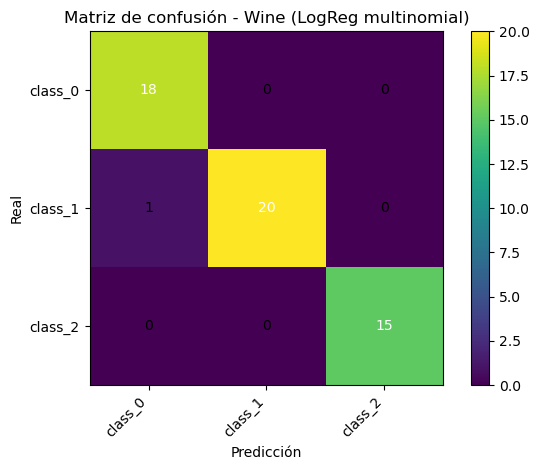

In [27]:
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión - Wine (LogReg multinomial)')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, ha='right')
plt.yticks(tick_marks, target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')

# Etiquetas numéricas en cada celda
th = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j] > th else 'black')

plt.tight_layout()
plt.show()

## 5. ROC/AUC multiclase (macro y micro) con curvas por clase

- Regla clave (arreglo del error): entrenamos con `y` 1D y binarizamos solo `y_test` para ROC.


In [28]:
# Binarizar SOLO y_test para ROC multiclase OvR
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilidades por calse (Softmax)
y_score = base_pipe.predict_proba(X_test)  # shape: (n_shape, n_classes)

# AUC promedio
auc_macro = roc_auc_score(y_test_bin, y_score, multi_class="ovr", average="macro")
auc_micro = roc_auc_score(y_test_bin, y_score, multi_class="ovr", average="micro")
print(f"AUC macro (OvR): {auc_macro:.3f}")
print(f"AUC micro (OvR): {auc_micro:.3f}")

AUC macro (OvR): 1.000
AUC micro (OvR): 0.999


## 6. Gráfico de curvas ROC por clase

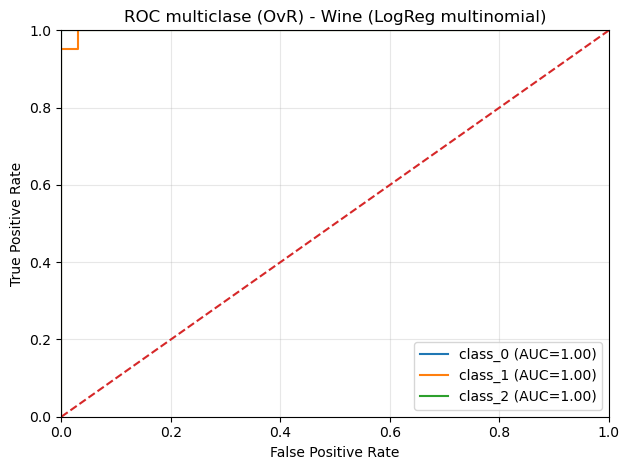

In [29]:
fpr, tpr, roc_auc = {}, {}, {}
n_classes = len(classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{target_names[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC multiclase (OvR) - Wine (LogReg multinomial)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Búsqueda de hiperparámetros (GridSearchCV)

- Ajustar C (fuerza de regularización; menor C => regularización más fuerte).
- Mantener `multinomial` + `lbfgs`
- CV estratificado por defecto (para clasificación), evita fuga y sobreajuste

In [31]:
param_grid = {
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
}

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=1,
    refit=True
)
grid.fit(X_train, y_train)

print('Mejores params:', grid.best_params_)
best_pipe = grid.best_estimator_

# Evaluación del mejor modelo
y_pred_best = best_pipe.predict(X_test)
print("== Reporte (mejor modelo) ==")
print(classification_report(y_test, y_pred_best, target_names=target_names))

# AUC macro/micro del mejor modelo
y_score_best = best_pipe.predict_proba(X_test)
auc_macro_best = roc_auc_score(label_binarize(y_test, classes=classes), y_score_best, multi_class="ovr", average="macro")
auc_micro_best = roc_auc_score(label_binarize(y_test, classes=classes), y_score_best, multi_class="ovr", average="micro")
print(f"AUC macro BEST: {auc_macro_best:.3f} | AUC micro BEST: {auc_micro_best:.3f}")


Mejores params: {'clf__C': 0.5}
== Reporte (mejor modelo) ==
              precision    recall  f1-score   support

     class_0       0.95      1.00      0.97        18
     class_1       1.00      0.95      0.98        21
     class_2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

AUC macro BEST: 1.000 | AUC micro BEST: 0.999


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

## 8. Interpretar coeficientes (insight del modelo)

- Enteder qué variables empujan cada clase (coeficientes positivos/negativos).


In [32]:
# Accede al clasificador entrenado dentro del pipeline
clf = best_pipe.named_steps["clf"]

# clf.coef_.shape = (n_clases, n_features)
for i, cls_name in enumerate(target_names):
    coefs = clf.coef_[i]
    top = np.argsort(np.abs(coefs))[::-1][:5]  # Top 5 por magnitud
    print(f"\nTop 5 features para clase '{cls_name}':")
    for j in top:
        signo = "↑" if coefs[j] > 0 else "↓"
        print(f"  {feature_names[j]:25s} coef={coefs[j]: .3f} {signo}")



Top 5 features para clase 'class_0':
  proline                   coef= 0.756 ↑
  alcalinity_of_ash         coef=-0.683 ↓
  alcohol                   coef= 0.634 ↑
  flavanoids                coef= 0.571 ↑
  od280/od315_of_diluted_wines coef= 0.469 ↑

Top 5 features para clase 'class_1':
  alcohol                   coef=-0.808 ↓
  proline                   coef=-0.775 ↓
  color_intensity           coef=-0.687 ↓
  ash                       coef=-0.629 ↓
  hue                       coef= 0.556 ↑

Top 5 features para clase 'class_2':
  flavanoids                coef=-0.717 ↓
  hue                       coef=-0.629 ↓
  color_intensity           coef= 0.599 ↑
  od280/od315_of_diluted_wines coef=-0.509 ↓
  proanthocyanins           coef=-0.431 ↓


## 9. Análisis de errores (casos mal clasificados)

- Saber qué confunde al modelo y por qué.

In [33]:
mis_idx = np.where(y_pred_best != y_test)[0]
print(f"Errores en test: {len(mis_idx)}")
for idx in mis_idx[:10]:
    print(f"Idx {idx} -> real: {target_names[y_test[idx]]} | pred: {target_names[y_pred_best[idx]]}")


Errores en test: 1
Idx 24 -> real: class_1 | pred: class_0


## Tarea

Comprobar impacto de esquema multiclase y del balanceo automático.
1. Repite el flujo con dos modelos adicionales (cada uno en su `Pipeline` con `StandardScaler`):
    - OvR: `LogisticRegression(multi_class="ovr", solver="liblinear", max_iter=200)`
    - Multinomial + balanceo: `LogisticRegression(multi_class="multinomial", solver="lbfgs", class_weight="balanced", max_iter=200)`
2. Para cada modelo, reporta:
    - `classification_report` (incluye macro/weighted F1).
    - Matriz de confusión (números y gráfico).
    - AUC macro y micro (con `y_test` binarizado y `predict_proba`).
    - Top-5 features por clase (como arriba).
3. Compara:
    - ¿Cuál da mejor F! macro? ¿Por qué crees?
    - ¿Mejor AUC micro**?
    - ¿El `class_weight="balanced"` ayudó a equilibrar clases? ¿Se nota en recall de la(s) clase(s) minoritaria(s)?

X_shape: (178, 13)
y_shape: (178,)
Clases: [0 1 2] -> ['class_0' 'class_1' 'class_2']
Clase 0 (class_0): 59 muestras
Clase 1 (class_1): 71 muestras
Clase 2 (class_2): 48 muestras

OvR: LogisticRegression(liblinear)

Reporte de Clasificación
              precision    recall  f1-score   support

     class_0      0.947     1.000     0.973        18
     class_1      1.000     0.952     0.976        21
     class_2      1.000     1.000     1.000        15

    accuracy                          0.981        54
   macro avg      0.982     0.984     0.983        54
weighted avg      0.982     0.981     0.982        54

F1 (macro): 0.983
F1 (weighted): 0.982

Matriz de confusión:
[[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


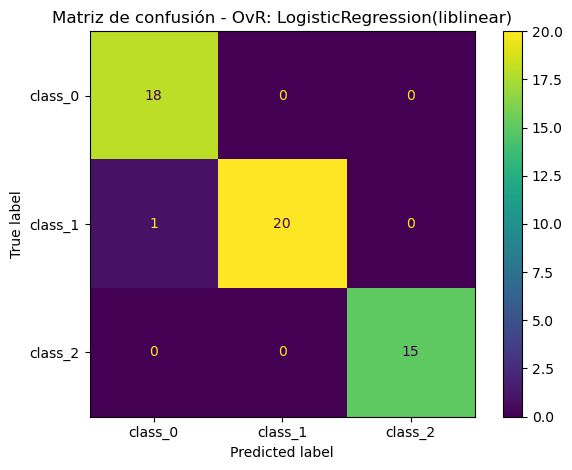

AUC (macro, OvR): 0.997
AUC (micro, OvR): 0.998


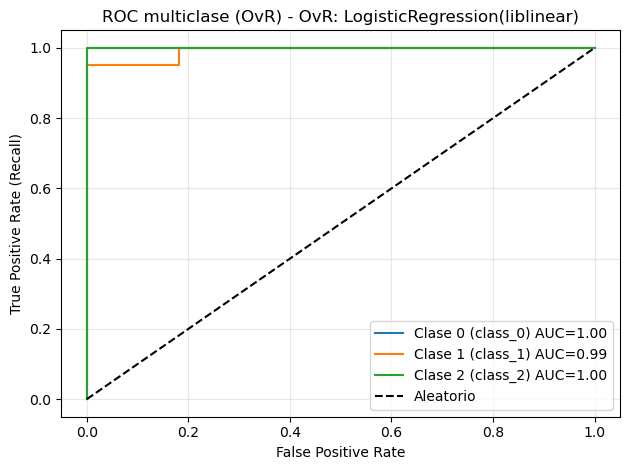


Top-5 features por clase (por |coef|, con signo):
  - Clase 0 (class_0):
                        proline  ->   1.5782
              alcalinity_of_ash  ->  -1.3603
                        alcohol  ->   1.2297
                     flavanoids  ->   1.1107
      od280/od315_of_diluted_wines  ->   0.7440
  - Clase 1 (class_1):
                        proline  ->  -1.5468
                        alcohol  ->  -1.4713
                color_intensity  ->  -1.3913
                            ash  ->  -1.1195
                            hue  ->   0.9916
  - Clase 2 (class_2):
                     flavanoids  ->  -1.2870
                color_intensity  ->   1.2392
                            hue  ->  -0.9928
      od280/od315_of_diluted_wines  ->  -0.6885
                proanthocyanins  ->  -0.4854

Multinomial + balanceado: LogisticRegression(lbfgs, class_weight=balanced)

Reporte de Clasificación
              precision    recall  f1-score   support

     class_0      0.947     1.000     0.97

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


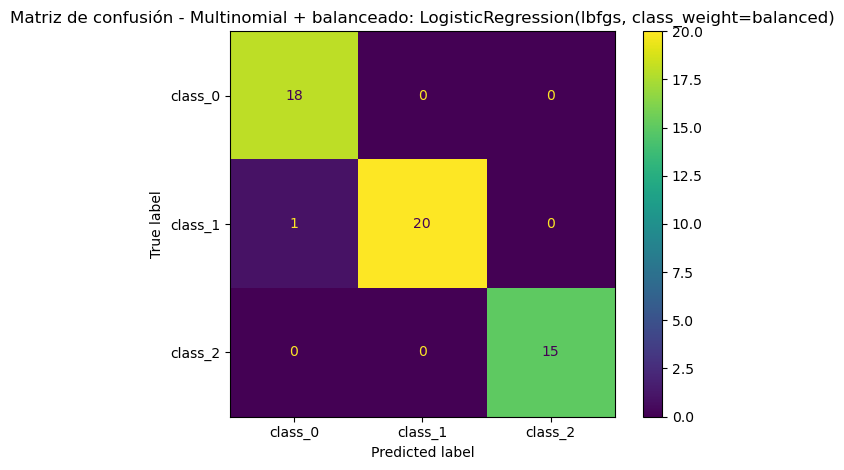

AUC (macro, OvR): 1.000
AUC (micro, OvR): 0.999


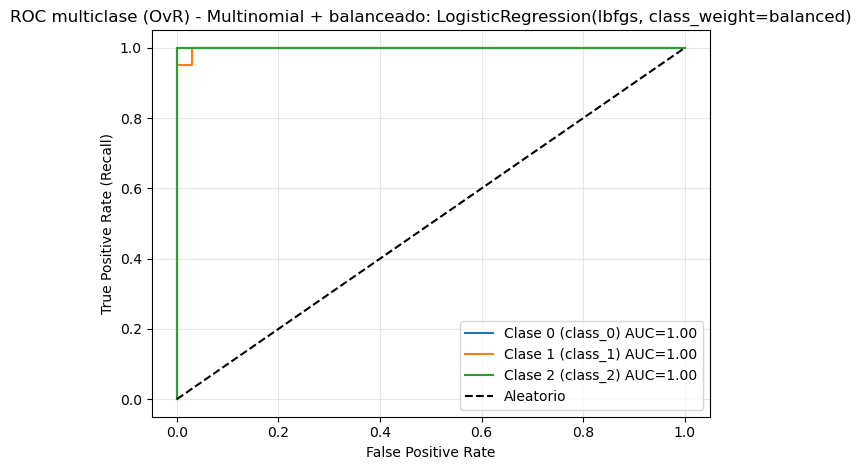


Top-5 features por clase (por |coef|, con signo):
  - Clase 0 (class_0):
                        proline  ->   0.8566
              alcalinity_of_ash  ->  -0.8199
                        alcohol  ->   0.7275
                     flavanoids  ->   0.6805
      od280/od315_of_diluted_wines  ->   0.5642
  - Clase 1 (class_1):
                        alcohol  ->  -0.9384
                        proline  ->  -0.9175
                color_intensity  ->  -0.7966
                            ash  ->  -0.7617
                            hue  ->   0.6961
  - Clase 2 (class_2):
                     flavanoids  ->  -0.8823
                            hue  ->  -0.7722
                color_intensity  ->   0.7195
      od280/od315_of_diluted_wines  ->  -0.5699
                proanthocyanins  ->  -0.5470


In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_curve,
    auc, roc_auc_score, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names
target_names = wine.target_names
classes = np.unique(y)   # NECESARIO para binarizar después

print("X_shape:", X.shape)
print("y_shape:", y.shape)
print("Clases:", np.unique(y), "->", target_names)

unique, counts = np.unique(y, return_counts=True)
for c, n in zip(unique, counts):
    print(f"Clase {c} ({target_names[c]}): {n} muestras")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipelines
pipeline_ovr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="ovr",
        solver="liblinear",
        max_iter=200,
        random_state=42
    ))
])

pipeline_multinomial = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=200,
        random_state=42
    ))
])

def evaluar(nombre, pipeline):
    print("\n" + "="*40)
    print(nombre)
    print("="*40)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("\nReporte de Clasificación")
    print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

    # F1 explícitos macro/weighted
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    print(f"F1 (macro): {f1_macro:.3f}")
    print(f"F1 (weighted): {f1_weighted:.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\nMatriz de confusión:")
    print(cm)

    # Gráfico
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(values_format='d')
    plt.title(f"Matriz de confusión - {nombre}")
    plt.tight_layout()
    plt.show()

    # Probabilidades y ROC/AUC
    if hasattr(pipeline.named_steps["clf"], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=classes)

        auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
        auc_micro = roc_auc_score(y_test_bin, y_proba, average="micro", multi_class="ovr")
        print(f"AUC (macro, OvR): {auc_macro:.3f}")
        print(f"AUC (micro, OvR): {auc_micro:.3f}")

        # Curvas ROC por clase
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(len(classes)):
            plt.plot(fpr[i], tpr[i], label=f'Clase {i} ({target_names[i]}) AUC={roc_auc[i]:.2f}')
        plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title(f"ROC multiclase (OvR) - {nombre}")
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\nEl estimador no implementa predict_proba; no se calculan ROC/AUC.")

    # Top-5 features por clase
    clf = pipeline.named_steps["clf"]
    if hasattr(clf, "coef_"):
        coefs = clf.coef_
        k = min(5, coefs.shape[1])
        print("\nTop-5 features por clase (por |coef|, con signo):")
        for i in range(coefs.shape[0]):
            w = coefs[i]
            idx = np.argsort(np.abs(w))[::-1][:k]
            print(f"  - Clase {i} ({target_names[i]}):")
            for j in idx:
                # Opción A: siempre mostrar el signo (+/-)
                # print(f"      {feature_names[j]:>25s}  ->  {w[j]:+.4f}")

                # Opción B: espacio para positivos, '-' para negativos
                print(f"      {feature_names[j]:>25s}  ->  {w[j]: .4f}")


# Ejecutar evaluaciones
evaluar("OvR: LogisticRegression(liblinear)", pipeline_ovr)
evaluar("Multinomial + balanceado: LogisticRegression(lbfgs, class_weight=balanced)", pipeline_multinomial)
